# Linear regression on property crimes

## Summary
### Data preparation
White space and new lines in the column names were removed. The data sets includes many variables that are not needed according to the assignment, so I deleted those. All remaining variables are complete for 348 cities.
The data includes one major outlier population vice: New York City with over 8 million is 32 bigger than the next biggest city Buffalo. Therefore I removed the New York city data. 
### Linear Model
#### Using the assignment variables
I run the linear model both on the raw data including New York and the data without information about New York.
Most of the variance in the data is explained by the binary murder column.
Keeping the NY data leads to overfitting ( R^2=0.99), whereas removing it leads to R^2 =0.84.
#### Without converting the murder and robbery variables to binaries
Eventhough murder and robbery are not normally distributed using those variables, does not completely ruin the model, actually this yields the best score. There is apparently a connection between the amount of robbery and murder and property crimes in a certain city.
#### Removing Population^2
Not including population^2 reduces the prediction power from R^2 =0.84 to 0.78 for the dataset without New York and binary variables.
#### Including the remaining variables (Aggravated assault,Rape (legacy definition)2)
Including further variables in the model as suggested by the assignment, without adjusting them to normal distribution leads to overfitting: R^2 = 0.999.

### Result
For the suggested model best results were achieved when excluding New York City data. The most predictive power resulted surprisingly from the binary murder column (195.038666).
The best predcitive power for a model was achieved using the continous variables for robbery and murder instead of binaries, together with population and population squared, again the murder columns was the most predicitive variable (102.64).


## Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  Robbery and Murder are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready.  Don't forget basic data cleaning procedures, either!  Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
from IPython.display import display
import math


pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls", skiprows=4,skip_footer=3)
df.head()

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\pandas\util\_decorators.py:177: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


### Data exploration

In [3]:
df.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,348.000,348.000,348.000,0.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,nan,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,nan,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,nan,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,nan,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,nan,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,nan,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


In [4]:
#print('Cities:\n', df['City'].unique())
print('Total number of cities:', len(df['City'].unique()))

Total number of cities: 348


### Clean the data set

In [5]:
# Remove the new lines in the column names
df1 = df
df1.columns= df1.columns.str.replace('\n',' ')

# Remove left and right white space from towns
df1.City = df1.City.str.lstrip()
df1.City = df1.City.str.rstrip()

# Drop unimportant variables
dfi = df1[['City','Population','Murder and nonnegligent manslaughter','Robbery','Property crime']]

# Check how many data is missing
def check_nans(dfi):
    for column in dfi.columns.unique():
        print(column,":",dfi[column].isnull().sum()/dfi.shape[0]*100 ,"% is Nan")

check_nans(dfi)

City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


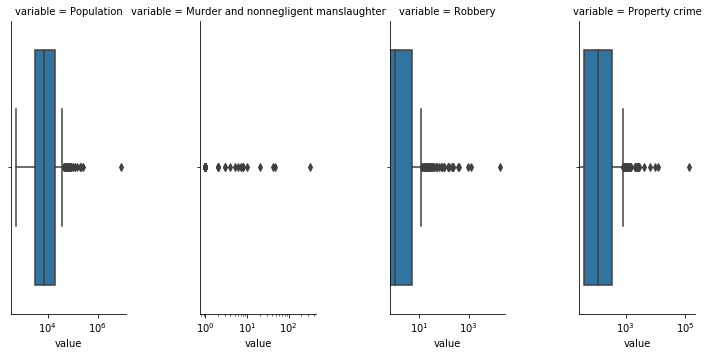

In [6]:
# Check for outliers in important variables
dfis = pd.melt(dfi, id_vars=['City'])
dfis.head()
g = sns.FacetGrid(dfis, col="variable",sharey=False,sharex=False, col_wrap=5, size=5, aspect=.5)
g = (g.map(sns.boxplot, "value"))
g=g.set(xscale="log")



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


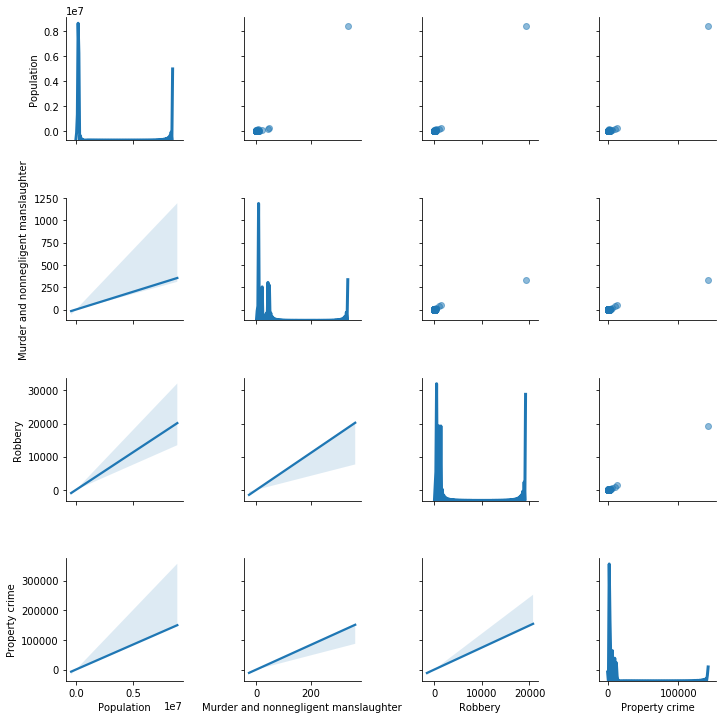

In [7]:
# Make a scatterplot matrix.
g = sns.PairGrid(dfi.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Variables are correlated.\n
Distribution of most variables are not normal, because of few high outliers. \n

In [8]:
# Sort data by population
dfi.sort_values(by=['Population'], ascending =False).head()

,City,Population,Murder and nonnegligent manslaughter,Robbery,Property crime
216,New York,8396126,335,19170,141971
35,Buffalo,258789,47,1322,12491
272,Rochester,210562,42,918,10051
346,Yonkers,199134,6,390,2368
310,Syracuse,143834,21,400,6473


The highest outlier population-vice is New York. Therefore, I remove New York data.

In [9]:
# Remove New York data point
dfi_noNY= dfi[dfi['City'] != 'New York']
print(dfi_noNY.sort_values(by=['Population'], ascending =False).head())

             City  Population  Murder and nonnegligent manslaughter  Robbery  \
35        Buffalo      258789                                    47     1322   
272     Rochester      210562                                    42      918   
346       Yonkers      199134                                     6      390   
310      Syracuse      143834                                    21      400   
7    Amherst Town      118296                                     1       31   

     Property crime  
35            12491  
272           10051  
346            2368  
310            6473  
7              2118  


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


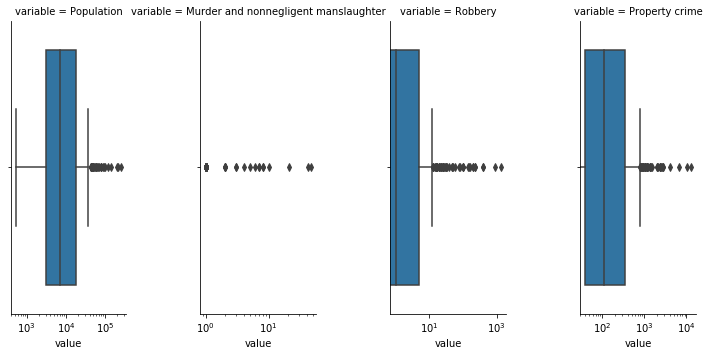

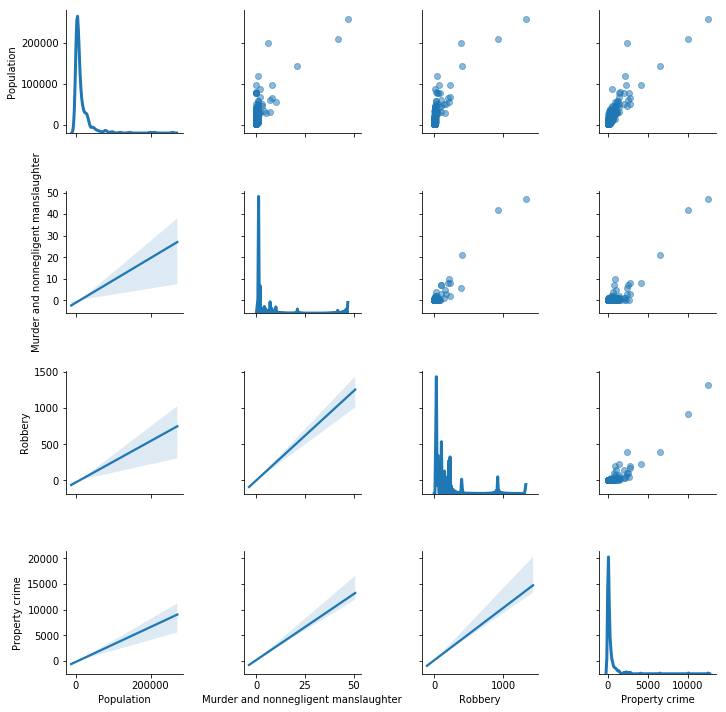

In [10]:
# Recheck data 
df2s = pd.melt(dfi_noNY, id_vars=['City'])
df2s.head()
g = sns.FacetGrid(df2s, col="variable",sharey=False,sharex=False, col_wrap=5, size=5, aspect=.5)
g = (g.map(sns.boxplot, "value"))
g=g.set(xscale="log")

# Make a scatterplot matrix.
g = sns.PairGrid(dfi_noNY.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

 Robbery and murder have outlier as well, but these variables will be converted into binaries anyway, therefore I ignore them.

### Generate new features

In [11]:
# Generate new features based on the instruction of the assignment
dfi['Population^2']=dfi['Population']**2
dfi['Murder_Bi']=np.where(dfi['Murder and nonnegligent manslaughter']>0, 1, 0)
dfi['Robbery_Bi']=np.where(dfi['Robbery']>0, 1, 0)
# Not corrected for outliers except for NY
dfi_noNY['Population^2']=dfi_noNY['Population']**2
dfi_noNY['Murder_Bi']=np.where(dfi_noNY['Murder and nonnegligent manslaughter']>0, 1, 0)
dfi_noNY['Robbery_Bi']=np.where(dfi_noNY['Robbery']>0, 1, 0)
#print(dfi_noNY.head())

# Generate new features based on the instruction of the assignment
df1['Population^2']=df1['Population']**2
df1['Murder_Bi']=np.where(df1['Murder and nonnegligent manslaughter']>0, 1, 0)
df1['Robbery_Bi']=np.where(df1['Robbery']>0, 1, 0)

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

## Generate Model
$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

Assignment: <br>
Now that you've spent some time playing with a sample multivariate linear regression model, it's time to make your own.<br>
<br>
You've already gotten started by prepping the FBI:UCR Crime dataset (Thinkful mirror) in a previous assignment.<br>
<br>
Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather han understanding mechanisms, so the focus is on creating a model that explains a lot of variance.<br>
<br>
Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

In [12]:
target = df['Property crime'].values.reshape(-1, 1) #Y
data = df[['Population','Population^2','Murder_Bi','Robbery_Bi']] #X
    
def lin_model(data, target):
    # Instantiate and fit model for outlier-corrected data
    regr = linear_model.LinearRegression()

    #data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=20)
    
    regr.fit(data, target)

    # Inspect the results.
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared: \n', regr.score(data, target))
    # Extract predicted values.
    predicted = regr.predict(data).ravel()
    actual = target.ravel()

    # Calculate the error, also called the residual.
    residual = actual - predicted

    # Error histogram
    plt.hist(residual)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()

    # Error scatter plot
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()
     


Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

Intercept: 
 [-109.57533562]

R-squared: 
 0.9961247104988709


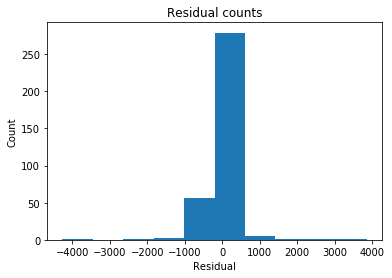

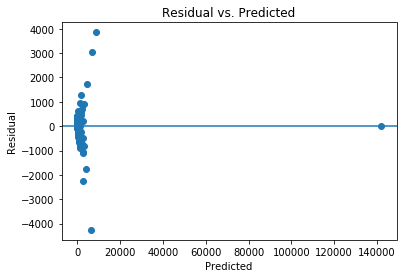

In [13]:
# modified raw data including New York city
target = dfi['Property crime'].values.reshape(-1, 1) #Y
data = dfi[['Population','Population^2','Murder_Bi','Robbery_Bi']] #X
lin_model(data, target)
#this leads to overfitting



Coefficients: 
 [[1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]]

Intercept: 
 [-16.81586632]

R-squared: 
 0.8444937611173492


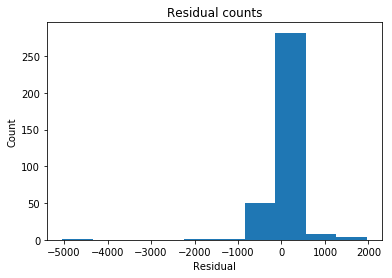

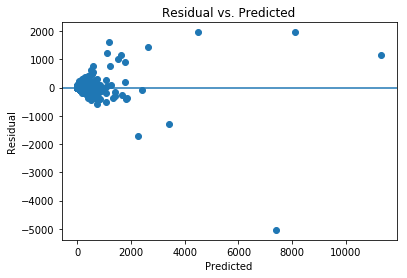

In [14]:
# modified raw data including New York city
target = dfi_noNY['Property crime'].values.reshape(-1, 1) #Y
data = dfi_noNY[['Population','Population^2','Murder_Bi','Robbery_Bi']] #X

lin_model(data,target)


Coefficients: 
 [[ 2.05519792e-02 -7.19468320e-08  1.02643383e+02  5.13001360e+00]]

Intercept: 
 [-25.0398582]

R-squared: 
 0.939283140822447


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


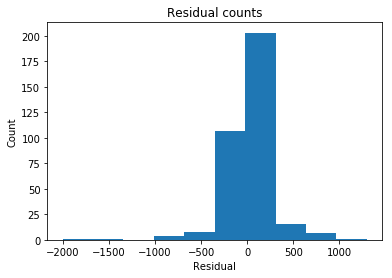

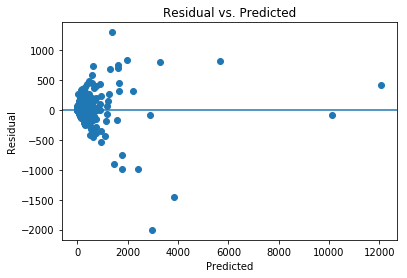

In [15]:
# modified raw data including New York city but using Murder and Robbery a continous variables
dfi_noNY['Murder']=dfi_noNY['Murder and nonnegligent manslaughter']

target = dfi_noNY['Property crime'].values.reshape(-1, 1) #Y
data = dfi_noNY[['Population','Population^2','Murder','Robbery']] #X

lin_model(data,target)